# **Dataset unlabeled**

In [55]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import sys
path_to_module = '/Users/cesaraugustoseminarioyrigoyen/Documents/CORSI/DATA_SCIENCE_POLI/3_year/Applied Data science/P8-project/PPS-MLC/functions/utils.py'
sys.path.append(path_to_module)
import os
sys.path.append(os.path.dirname(path_to_module))
import utils

#P8 polito github - project import
#!git clone https://github.com/adsp-polito/2024-P8-PPS.git
unlabeled_dataset=pd.read_excel('data_Int_not_labeled.xlsx').drop(columns=['Unnamed: 0'])

In [56]:
print(f"size of dataset: {unlabeled_dataset.shape}")
unlabeled_dataset.head(3)

size of dataset: (1006, 8)


,Title,Abstract,telemedicine,imaging,surgery,drug,screening,device
0,design feature participant characteristic infl...,research participate tended limited single ind...,0,0,0,0,0,0
1,value meaning rural primary practice implicati...,understand unique perspective value motivate c...,0,0,0,0,0,0
2,cultural influence asian american metasynthesis,summarize asian american negotiate involvement...,0,0,0,0,0,0


In [57]:
stats=utils.show_stats_of_titles_abstracts(unlabeled_dataset)

Average Title Length: 6.86 words
Average Abstract Length: 115.66 words
Number of rows with Anomalies in the Title: 14
Number of rows with Anomalies in the Abstract: 48


# **Topic modeling BERTopic**

## test with chatgpt for bertopic 

In [22]:
from bertopic import BERTopic
from sklearn.feature_extraction.text import CountVectorizer
from umap import UMAP
from hdbscan import HDBSCAN
from sentence_transformers import SentenceTransformer
from sklearn.metrics import pairwise_distances
from bertopic.representation import MaximalMarginalRelevance
from gensim.models.coherencemodel import CoherenceModel
from gensim.corpora.dictionary import Dictionary



In [25]:
def calculate_diversity(topic_model):
    topics = topic_model.get_topics()
    topic_words = [set([word for word, _ in words]) for words in topics.values() if words]
    unique_words = set().union(*topic_words)
    return len(unique_words) / sum(len(words) for words in topic_words)
# Funzione per calcolare coherence e diversity
def evaluate_model(topic_model, documents):
    coherence = topic_model.get_coherence()
    topics = topic_model.get_topic_freq().head(10)['Topic']
    diversity = topic_model.diversity_score(documents)
    return coherence, diversity

def calculate_coherence(topic_model, documents): #still having problems with this function
    topics = topic_model.get_topics()
    top_words = [[word for word, _ in words] for words in topics.values() if words]
    # Rimuove eventuali liste vuote
    top_words = [words for words in top_words if len(words) > 0]
    flattened_docs = [doc.split() for doc in documents]

    # Creazione del dizionario e del corpus
    dictionary = Dictionary(flattened_docs)
    corpus = [dictionary.doc2bow(doc) for doc in flattened_docs]

    coherence_model = CoherenceModel(
        topics=top_words, texts=flattened_docs, dictionary=dictionary, coherence='c_v'
    )
    return coherence_model.get_coherence()

# ***BERT Pipeline***

BERTopic can be viewed as a sequence of steps to create its topic representations. There are five steps to this process:

![https://maartengr.github.io/BERTopic/algorithm/default.svg](https://maartengr.github.io/BERTopic/algorithm/default.svg)

## **Dimensionality reduction && Clustering**

Dimensionality reduction
*   Reduce the size of the embeddings to a certain degree. [Curse of dimensionality](https://en.wikipedia.org/wiki/Curse_of_dimensionality)

*   default [UMAP](https://github.com/lmcinnes/umap) with random_state=42 for repeatability



Clustering
- `nr_topics` is a parameter which controls directly the number of topics,  **after** they have been created

- `min_cluster_size` indirectly controls the number of topics that will be created (advised)


In [6]:
# from umap import UMAP

# umap_model = UMAP(n_neighbors=30, n_components=5, min_dist=0.0, metric='cosine', random_state=42)
# from hdbscan import HDBSCAN

# hdbscan_model = HDBSCAN(min_cluster_size=20, metric='euclidean', cluster_selection_method='eom', prediction_data=True)

In [29]:

# Creating params to test
umap_params = [
    {"n_neighbors": 10, "n_components": 2},
    {"n_neighbors": 10, "n_components": 5},
    {"n_neighbors": 20, "n_components": 2},
    {"n_neighbors": 20, "n_components": 5},
    {"n_neighbors": 30, "n_components": 2},
    {"n_neighbors": 30, "n_components": 5}
]

hdbscan_params = [
    {"min_cluster_size": 10, "min_samples": 1},
    {"min_cluster_size": 10, "min_samples": 2},
    {"min_cluster_size": 20, "min_samples": 2}
]

embedding_models = [
    #SentenceTransformer("sentence-transformers/all-MiniLM-L6-v2"),
    SentenceTransformer("neuml/pubmedbert-base-embeddings")

]


## **Tokenizer**
*   Default representation of topics is calculated through [c-TF-IDF](https://maartengr.github.io/BERTopic/algorithm/algorithm.html#5-topic-representation).
*   c-TF-IDF is powered by the [CountVectorizer](https://maartengr.github.io/BERTopic/getting_started/vectorizers/vectorizers.html) which converts text into tokens. Using the CountVectorizer, we can remove stopwords, ignore infrequent words --> improve default representation



In [8]:
from sklearn.feature_extraction.text import CountVectorizer
vectorizer_model = CountVectorizer(stop_words="english", min_df=2, ngram_range=(1, 2))

## **Representation tuning** not used at the moment -  SKIP
- [other topic representations](https://maartengr.github.io/BERTopic/getting_started/representation/representation.html) : [KeyBERTInspired](https://maartengr.github.io/BERTopic/getting_started/representation/representation.html#keybertinspired) and [PartOfSpeech](https://maartengr.github.io/BERTopic/getting_started/representation/representation.html#partofspeech), or [OpenAI's ChatGPT](https://maartengr.github.io/BERTopic/getting_started/representation/llm.html#chatgpt) and [open-source](https://maartengr.github.io/BERTopic/getting_started/representation/llm.html#langchain) alternatives.

- In BERTopic, you can model many different topic representations simultanously. This is called [multi-aspect](https://maartengr.github.io/BERTopic/getting_started/multiaspect/multiaspect.html) topic modeling.


### **LLM representations**

#### *Zephyr*

In [ ]:
#!pip install ctransformers[cuda]
#!pip install --upgrade git+https://github.com/huggingface/transformers
#load a quantized model which is a compressed version of the original model
from ctransformers import AutoModelForCausalLM
from transformers import AutoTokenizer, pipeline

In [ ]:
# Set gpu_layers to the number of layers to offload to GPU. Set to 0 if no GPU acceleration is available on your system.
model = AutoModelForCausalLM.from_pretrained(
    "TheBloke/zephyr-7B-alpha-GGUF",
    model_file="zephyr-7b-alpha.Q4_K_M.gguf",
    model_type="mistral",
    gpu_layers=50,
    hf=True
)
tokenizer = AutoTokenizer.from_pretrained("HuggingFaceH4/zephyr-7b-alpha")

# Pipeline
generator = pipeline(
    model=model, tokenizer=tokenizer,
    task='text-generation',
    max_new_tokens=50,
    repetition_penalty=1.1
)


In [ ]:
prompt = """<|system|>You are a helpful, respectful and honest assistant for labeling topics..</s>
<|user|>
I have a topic that contains the following documents:
[DOCUMENTS]

The topic is described by the following keywords: '[KEYWORDS]'.

Based on the information about the topic above, please create a short label of this topic. Make sure you to only return the label and nothing more.</s>
<|assistant|>"""

In [ ]:
from bertopic.representation import TextGeneration

# Text generation with Zephyr
zephyr_model = TextGeneration(generator, prompt=prompt)


#### *Llama*

In [10]:
#need to login with huggingface token
from huggingface_hub import notebook_login
notebook_login()
from torch import cuda

model_id = 'meta-llama/Llama-2-7b-chat-hf'
device = f'cuda:{cuda.current_device()}' if cuda.is_available() else 'cpu'

print(device)

cpu


In [ ]:
#!pip install accelerate bitsandbytes xformers adjustText
#!apt install -U bitsandbytes
from torch import bfloat16
import transformers

# set quantization configuration to load large model with less GPU memory
# this requires the `bitsandbytes` library
bnb_config = transformers.BitsAndBytesConfig(
    load_in_4bit=True,  # 4-bit quantization
    bnb_4bit_quant_type='nf4',  # Normalized float 4
    bnb_4bit_use_double_quant=True,  # Second quantization after the first
    bnb_4bit_compute_dtype=bfloat16  # Computation type
)

# Llama 2 Tokenizer
tokenizer = transformers.AutoTokenizer.from_pretrained(model_id)

# Llama 2 Model
model = transformers.AutoModelForCausalLM.from_pretrained(
    model_id,
    trust_remote_code=True,
    quantization_config=bnb_config,
    device_map='auto',
)
model.eval()

# Our text generator
generator = transformers.pipeline(
    model=model, tokenizer=tokenizer,
    task='text-generation',
    temperature=0.1,
    max_new_tokens=500,
    repetition_penalty=1.1
)


In [ ]:
# System prompt describes information given to all conversations
system_prompt = """
<s>[INST] <<SYS>>
You are a helpful, respectful and honest assistant for labeling topics.
<</SYS>>
"""

# Example prompt demonstrating the output we are looking for
example_prompt = """
I have a topic that contains the following documents:
- Traditional diets in most cultures were primarily plant-based with a little meat on top, but with the rise of industrial style meat production and factory farming, meat has become a staple food.
- Meat, but especially beef, is the word food in terms of emissions.
- Eating meat doesn't make you a bad person, not eating meat doesn't make you a good one.

The topic is described by the following keywords: 'meat, beef, eat, eating, emissions, steak, food, health, processed, chicken'.

Based on the information about the topic above, please create a short label of this topic. Make sure you to only return the label and nothing more.

[/INST] Environmental impacts of eating meat
"""

# Our main prompt with documents ([DOCUMENTS]) and keywords ([KEYWORDS]) tags
main_prompt = """
[INST]
I have a topic that contains the following documents:
[DOCUMENTS]

The topic is described by the following keywords: '[KEYWORDS]'.

Based on the information about the topic above, please create a short label of this topic. Make sure you to only return the label and nothing more.
[/INST]
"""

prompt = system_prompt + example_prompt + main_prompt


In [ ]:
from bertopic.representation import TextGeneration
#from bertopic import BERTopic

# Text generation with Llama 2
llama2_model = TextGeneration(generator, prompt=prompt)


In [ ]:
#llama_model = LlamaCPP("/content/zephyr-7b-alpha.Q4_K_M.gguf")


#### OpenAI

In [ ]:
from bertopic.representation import OpenAI

In [ ]:
# GPT-3.5
prompt = """
I have a topic that contains the following documents:
[DOCUMENTS]
The topic is described by the following keywords: [KEYWORDS]

Based on the information above, extract a short but highly descriptive topic label of at most 5 words. Make sure it is in the following format:
topic: <topic label>
"""
client = openai.OpenAI(api_key="sk-...")
openai_model = OpenAI(client, model="gpt-3.5-turbo",exponential_backoff=True, chat=True, prompt=prompt)

### other representations

In [9]:
#!pip install typing-extensions --upgrade

import openai
from bertopic.representation import KeyBERTInspired, MaximalMarginalRelevance, PartOfSpeech

# KeyBERT
keybert_model = KeyBERTInspired()

# Part-of-Speech
pos_model = PartOfSpeech("en_core_web_sm")

# MMR
mmr_model = MaximalMarginalRelevance(diversity=0.3)



# All representation models
representation_model = {
    "KeyBERT": keybert_model,
    #"OpenAI": openai_model,  # Uncomment if you will use OpenAI
    "MMR": mmr_model,
    "POS": pos_model,
    #"LLama2": llama2_model,
    #"Zephyr":zephyr_model
}

## **Embeddings**
Embeddings calculated in the binary classificator step. We load them in the ***embeddings*** variable

In [58]:
embedding_model = 'neuml/pubmedbert-base-embeddings'
papers,embeddings=utils.embedd(unlabeled_dataset,embedding_model)

Count NaN values:  62
Count empty values (NaN o empty strings): 62


Batches:   0%|          | 0/32 [00:00<?, ?it/s]

## **Training**
If you want to iterate over the topic model it is advised to use the pre-calculated embeddings as that significantly speeds up training.

In [59]:
import time
results = []

# Iterazione sui modelli
for umap_param in umap_params:
    for hdbscan_param in hdbscan_params:
        for embedding_model in embedding_models:
            # Configurazione del modello
            umap_model = UMAP(**umap_param)
            hdbscan_model = HDBSCAN(**hdbscan_param)
            vectorizer = vectorizer_model = CountVectorizer(stop_words="english", min_df=1, ngram_range=(1, 2))#CountVectorizer()

            topic_model = BERTopic(
                embedding_model=embedding_model,
                umap_model=umap_model,
                hdbscan_model=hdbscan_model,
                vectorizer_model=vectorizer,
                representation_model=MaximalMarginalRelevance(),

            )
            start = time.time()
            print(f"running model {umap_param} {hdbscan_param}")
            # Adattamento ai dati
            topics, probs = topic_model.fit_transform(papers,embeddings)
            end= time.time()
            # Valutazione
            #coherence = calculate_coherence(topic_model, papers)
            diversity = calculate_diversity(topic_model)

            results.append({
                "umap_params": umap_param,
                "hdbscan_params": hdbscan_param,
                "embedding_model": embedding_model,  # Modello come stringa
                #"coherence": coherence,
                "diversity": diversity,
                "topic_info": topic_model.get_topic_info(),
                "topics": topics
            })
            print(f"Time to run model: {end-start}")
            print(f"diversity: {diversity}")

running model {'n_neighbors': 10, 'n_components': 2} {'min_cluster_size': 10, 'min_samples': 1}
Time to run model: 40.99835920333862
running model {'n_neighbors': 10, 'n_components': 2} {'min_cluster_size': 10, 'min_samples': 2}
Time to run model: 31.43561816215515
running model {'n_neighbors': 10, 'n_components': 2} {'min_cluster_size': 20, 'min_samples': 2}
Time to run model: 17.553877115249634
running model {'n_neighbors': 10, 'n_components': 5} {'min_cluster_size': 10, 'min_samples': 1}
Time to run model: 31.154650688171387
running model {'n_neighbors': 10, 'n_components': 5} {'min_cluster_size': 10, 'min_samples': 2}
Time to run model: 30.359748125076294
running model {'n_neighbors': 10, 'n_components': 5} {'min_cluster_size': 20, 'min_samples': 2}
Time to run model: 14.725770235061646
running model {'n_neighbors': 20, 'n_components': 2} {'min_cluster_size': 10, 'min_samples': 1}
Time to run model: 31.79819416999817
running model {'n_neighbors': 20, 'n_components': 2} {'min_cluste

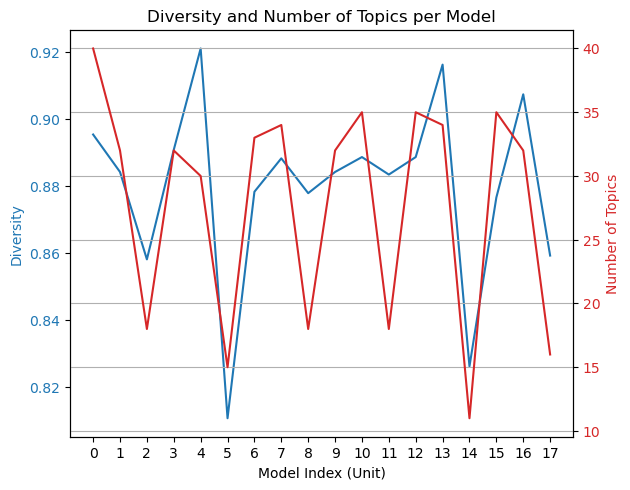

In [60]:
# Plot diversity vs number of topics to select the best model
# 
div=[results[i]['diversity'] for i in range(len(results))]
ntopics=[results[i]['topic_info'].shape[0] for i in range(len(results))]
fig, ax1 = plt.subplots()

color = 'tab:blue'
ax1.set_xlabel('Model Index (Unit)')
ax1.set_ylabel('Diversity', color=color)
ax1.plot(div, color=color)
ax1.tick_params(axis='y', labelcolor=color)
ax1.set_xticks(range(len(div)))

ax2 = ax1.twinx()
color = 'tab:red'
ax2.set_ylabel('Number of Topics', color=color)
ax2.plot(ntopics, color=color)
ax2.tick_params(axis='y', labelcolor=color)

fig.tight_layout()
plt.grid()
plt.title('Diversity and Number of Topics per Model')
plt.show()


In [61]:
results[13]['topic_info']

,Topic,Count,Name,Representation,Representative_Docs
0,-1,152,-1_experience_attribute_information_outcome,"[experience, attribute, information, outcome, ...",[eliciting people exercise program bestworst s...
1,0,102,0_breast cancer_lung cancer_sdm_oncology,"[breast cancer, lung cancer, sdm, oncology, on...",[clinician perspective support system lung can...
2,1,65,1_pain_practice_professional_low pain,"[pain, practice, professional, low pain, ra, c...",[people considering exercise prevent low back ...
3,2,61,2_advance_family_advance planning_acp,"[advance, family, advance planning, acp, surro...",[asian perspective advance planning mixedmetho...
4,3,57,3_utility_valuation_tradeoff_qaly,"[utility, valuation, tradeoff, qaly, time trad...",[utility value state ireland set objective dev...
5,4,40,4____,"[, , , , , , , , , ]","[ , , ]"
6,5,39,5_hta_attribute_value_regulatory,"[hta, attribute, value, regulatory, dces, tech...",[process cost attribute cancer experiment seve...
7,6,36,6_prostate_prostate cancer_men_decisional,"[prostate, prostate cancer, men, decisional, d...",[voice methodology novel mixedmethods approach...
8,7,31,7_sdm_clinician_da_practice,"[sdm, clinician, da, practice, pda, therapist,...",[safety net go sdm interactive process clinici...
9,8,29,8_healthcare_china_attribute_insurance,"[healthcare, china, attribute, insurance, qual...",[resident healthcare provider differ family do...


## **Final model**

In [63]:
#RETRAINING with model chosen: 13
model_index= 13
umap_param = results[model_index]['umap_params']
hdbscan_param = results[model_index]['hdbscan_params']
# Configurazione del modello
umap_model = UMAP(**umap_param)
hdbscan_model = HDBSCAN(**hdbscan_param)
vectorizer = vectorizer_model = CountVectorizer(stop_words="english", min_df=1, ngram_range=(1, 2))#CountVectorizer()

topic_model = BERTopic(
    embedding_model=embedding_model,
    umap_model=umap_model,
    hdbscan_model=hdbscan_model,
    vectorizer_model=vectorizer,
    representation_model=MaximalMarginalRelevance(),

)
start = time.time()
print(f"running model {umap_param} {hdbscan_param}")
# Adattamento ai dati
topics, probs = topic_model.fit_transform(papers,embeddings)
end= time.time()
# Valutazione


running model {'n_neighbors': 30, 'n_components': 2} {'min_cluster_size': 10, 'min_samples': 2}


# **MODEL FURTHER VISUALIZATIONS**

## **Topic-Document Distribution**
If using `calculate_probabilities=True` is not possible, than you can [approximate the topic-document distributions](https://maartengr.github.io/BERTopic/getting_started/distribution/distribution.html) using `.approximate_distribution`. It is a fast and flexible method for creating different topic-document distributions.

In [64]:
# `topic_distr` contains the distribution of topics in each document
topic_distr, _ = topic_model.approximate_distribution(papers, window=8, stride=4)

Next, lets take a look at a specific abstract and see how the topic distribution was extracted:

In [67]:
abstract_id = 11
print(papers[abstract_id])
# Visualize the topic-document distribution for a single document
topic_model.visualize_distribution(topic_distr[abstract_id])

healthcare associated factor adult admitted public hospital west shoa oromia ethiopia mean choice individual make medical experience belief value aim ass healthcare associated factor adult admitted public hospital west shoa oromia ethiopia crosssectional carried adult admitted public hospital west shoa oromia ethiopia intervieweradministered control scale questionnaire instrument tool used ass statistical performed spss window program version total respondent participated total respondent female overall respondent prefer collaborative role age aor ci marital status aor ci education level aor ci significant half respondent prefer collaborative role healthcare provider age marital status level education factor associated ethiopian ministry work policy healthcare provider consider


It seems to have extracted a number of topics that are relevant and shows the distributions of these topics across the abstract. We can go one step further and visualize them on a token-level:

In [68]:
# Calculate the topic distributions on a token-level
topic_distr, topic_token_distr = topic_model.approximate_distribution(papers[abstract_id], calculate_tokens=True)

# Visualize the token-level distributions
df = topic_model.visualize_approximate_distribution(papers[abstract_id], topic_token_distr[0])
df

,healthcare,associated,factor,adult,admitted,public,hospital,west,shoa,oromia,ethiopia,mean,choice,individual,make,medical,experience,belief,value,aim,ass,healthcare,associated,factor,adult,admitted,public,hospital,west,shoa,oromia,ethiopia,crosssectional,carried,adult,admitted,public,hospital,west,shoa,oromia,ethiopia,intervieweradministered,control,scale,questionnaire,instrument,tool,used,ass,statistical,performed,spss,window,program,version,total,respondent,participated,total,respondent,female,overall,respondent,prefer,collaborative,role,age,aor,ci,marital,status,aor,ci,education,level,aor,ci,significant,half,respondent,prefer,collaborative,role,healthcare,provider,age,marital,status,level,education,factor,associated,ethiopian,ministry,work,policy,healthcare,provider,consider
18_hospital_china_service_healthcare,0.000,0.000,0.000,0.122,0.239,0.351,0.462,0.340,0.222,0.111,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.122,0.239,0.351,0.462,0.340,0.222,0.111,0.000,0.000,0.000,0.122,0.239,0.351,0.462,0.340,0.222,0.111,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000


## **Visualize Topics**

With visualizations, we are closing into the realm of subjective "best practices". These are things that I generally do because I like the representations but your experience might differ.

Having said that, there are two visualizations that are my go-to when visualizing the topics themselves:

* `topic_model.visualize_topics()`
* `topic_model.visualize_hierarchy()`

In [69]:
topic_model.visualize_topics(custom_labels=True)

In [70]:
topic_model.visualize_hierarchy(custom_labels=True)

## **Visualize Documents**

When visualizing documents, it helps to have embedded the documents beforehand to speed up computation. Fortunately, we have already done that as a "best practice".

Visualizing documents in 2-dimensional space helps in understanding the underlying structure of the documents and topics.

In [71]:
# Reduce dimensionality of embeddings, this step is optional but much faster to perform iteratively:
reduced_embeddings = UMAP(n_neighbors=10, n_components=2, min_dist=0.0, metric='cosine').fit_transform(embeddings)

The following plot is **interactive** which means that you can zoom in, double click on a label to only see that one and generally interact with the plot:

In [72]:
# Visualize the documents in 2-dimensional space and show the titles on hover instead of the abstracts
# NOTE: You can hide the hover with `hide_document_hover=True` which is especially helpful if you have a large dataset
topic_model.visualize_documents(papers, reduced_embeddings=reduced_embeddings, custom_labels=True)

In [73]:
# We can also hide the annotation to have a more clear overview of the topics
topic_model.visualize_documents(papers, reduced_embeddings=reduced_embeddings, custom_labels=True, hide_annotations=True)

**💡  NOTE - 2-dimensional space 💡**
***
Although visualizing the documents in 2-dimensional gives an idea of their underlying structure, there is a risk involved.

Visualizing the documents in 2-dimensional space means that we have lost significant information since the original embeddings were more than 384 dimensions. Condensing all that information in 2 dimensions is simply not possible. In other words, it is merely an **approximation**, albeit quite an accurate one.
***

## **Serialization**

When saving a BERTopic model, there are several ways in doing so. You can either save the entire model with `pickle`, `pytorch`, or `safetensors`.

Personally, I would advise going with `safetensors` whenever possible. The reason for this is that the format allows for a very small topic model to be saved and shared.

When saving a model with `safetensors`, it skips over saving the dimensionality reduction and clustering models. The `.transform` function will still work without these models but instead assign topics based on the similarity between document embeddings and the topic embeddings.

As a result, the `.transform` step might give different results but it is generally worth it considering the smaller and significantly faster model.

In [ ]:
embedding_model = "sentence-transformers/all-MiniLM-L6-v2"
topic_model.save("my_model_dir", serialization="safetensors", save_ctfidf=True, save_embedding_model=embedding_model)

**💡  NOTE - Embedding Model 💡**
***
Using `safetensors`, we are not saving the underlying embedding model but merely a pointer to the model. For example, in the above example we are saving the string `"sentence-transformers/all-MiniLM-L6-v2"` so that we can load in the embedding model alongside the topic model.

This currently only works if you are using a sentence transformer model. If you are using a different model, you can load it in when loading the topic model like this:

```python
from sentence_transformers import SentenceTransformer

# Define embedding model
embedding_model = SentenceTransformer("all-MiniLM-L6-v2")

# Load model and add embedding model
loaded_model = BERTopic.load("path/to/my/model_dir", embedding_model=embedding_model)
```
***

As mentioned above, loading can be done as follows:

In [ ]:
from sentence_transformers import SentenceTransformer

# Define embedding model
embedding_model = SentenceTransformer("all-MiniLM-L6-v2")

# Load model and add embedding model
loaded_model = BERTopic.load("my_model_dir", embedding_model=embedding_model)